# ЗАДАНИЕ ПО ВЫЧМАТАМ
# ВАРИАНТ 7.5. Численное решение жесткой системы

In [2]:
import numpy as np
from math import sqrt
import scipy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
from sympy.interactive import printing
printing.init_printing(use_latex=True)
import seaborn as sns
from package_tqdm import *  # может быть конфликт имен до части II, но это не точно
sns.set()

# Суточные колебания концентрации озона в атмосфере
# Рассмотрим простейшую математическую модель колебаний концентрации озона в атмосфере
# Она описывается следующей неавтономной системой ОДУ

In [3]:
y1 = sp.Symbol('y1')
y2 = sp.Symbol('y2')
y3 = sp.Symbol('y3')
t = sp.Symbol('t')
k1 = sp.Symbol('k1')
k2 = sp.Symbol('k2')
k3 = sp.Symbol('k3')
k4 = sp.Symbol('k4')
omega = sp.Symbol('ω')
c3 = sp.Symbol('c3')
c4 = sp.Symbol('c4')
y1_0 = sp.Symbol('y1_0')
y2_0 = sp.Symbol('y2_0')
y3_0 = sp.Symbol('y3_0')  # определяем переменные LaTex
dydt_1 = sp.Function('y1')(y1,y2,y3,t)
dydt_2 = sp.Function('y2')(t)
dydt_3 = sp.Function('y3')(y1,y2,y3,t)  # определяем функции LaTex (уравнения системы)
dydt_1 = dydt_1.diff(t)
dydt_2 = dydt_2.diff(t)
dydt_3 = dydt_3.diff(t)  # вид dy/dt

In [95]:
def kineq(y1, y2, y3, k1, k2, k3, k4):  # функция доступа к уравнениям системы kinetic equation
    dydt_1 = -k1*y1*y2 - k2*y1*y3 + 2*k3*y2 + k4*y3
    dydt_2 = 0  # O2 вообще не считаем
    dydt_3 = k1*y1*y2 - k2*y1*y3 - k4*y3
    return {1:dydt_1, 2: dydt_2, 3:dydt_3}

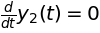

In [7]:
display(sp.Eq(dydt_1, kineq(y1, y2, y3, k1, k2, k3, k4)[1]))
display(sp.Eq(dydt_2, kineq(y1, y2, y3, k1, k2, k3, k4)[2]))
display(sp.Eq(dydt_3, kineq(y1, y2, y3, k1, k2, k3, k4)[3]))

# Определим параметры системы, начальные условия
# Параметры k3, k4 пока покажем оценочно, для представления картины

In [131]:
sp.Eq(omega,np.pi/43200), \
sp.Eq(k1,1.63e-16), \
sp.Eq(k2,4.66e-16), \
sp.Eq(k3, 0), \
sp.Eq(c3,22.62), \
sp.Eq(c4,7.601), \
sp.Eq(y1_0,1e6), \
sp.Eq(y2_0,3.7e16), \
sp.Eq(y1_0,1e12)  # вид, показано до определения

# Система умеренно жесткая днем

In [148]:
'k3 = 0, так и не хватило света',\
'k4 = array([5.03000000e+00, 5.06000000e+00, 5.09000000e+00, ..., \
        1.11149793e+06, 1.11316242e+06, 1.11482895e+06])'

('k3 = 0, так и не хватило света',
 'k4 = array([5.03000000e+00, 5.06000000e+00, 5.09000000e+00, ...,         1.11149793e+06, 1.11316242e+06, 1.11482895e+06])')

In [96]:
omega = np.pi/43200  # частота колебаний, c-1
k1, k2 = 1.63e-16, 4.66e-16  # константы скорости
c3, c4 = 22.62, 7.601  # константы дневных колебаний функции exp(-c/sin(wt)), функция определяет зависимость \ 
# k3 и k4 от времени

In [97]:
t = np.arange(0, 8084, 1)  # точки времени, возьмем небольшое время с шагом в 100 с
def light_dep(w, c, m):  # функция определения k3 и k4, зависимость от дневных колебаний, возвращает массив
    res = np.arange(0)
    for _ in t:
        if np.sin(w*_) <= 0.0:  # 
            continue
        elif round(np.exp(-c/np.sin(w*_))*m):  # округляем тысячные доли до нуля в сравнении с остальными членами y 
            res = np.append(res, round(np.exp(-c/np.sin(w*_))*10*m, 2))  
    if not res.size>0:
        res = 0  # если так и не было света (или слишком мало, округлили)
    return res

In [7]:
k3, k4 = light_dep(omega, c3, 1e15), light_dep(omega, c4, 1e11)  # округлили до -17 и -13 соответсвенно

In [98]:
y1_0, y2_0, y3_0 = 1e6, 3.7e16, 1e12  # начальные концентрации, см-3 

# Часть I
# Реализуем схему Розенброка CROS
# 1. Получим численное решение, шаг возьмем из других методов
# 2. Построим график решения
# 3. Построим функцию устойчивости

# Описание CROS

In [207]:
y_n = sp.Symbol('Yn')
h = sp.Symbol('h')
t = sp.Symbol('t')
re_w = sp.Symbol('Rew')
e = sp.Symbol('E')
j = sp.Symbol('J') 
gamma = sp.Symbol('γ')
w = sp.Symbol('w')
t0 = sp.Symbol('t0')
y0 = sp.Symbol('y0')
alpha = sp.Symbol('α')
y_n1 = sp.Function('Yn+1')(t)
x = sp.Function('')(t0+alpha*h)
f = sp.Function('f')(x, y0)

In [208]:
display(sp.Eq((e - gamma*h*j)*w, f))  # одностадийная схема Розенброка первого порядка аппроксимации, \
# L1 устойчивость, b = 1
display(sp.Eq(y_n1, y_n + h*re_w))  # итерационное решение 

In [210]:
gamma = 0.5 + 0.5j  # выберем гамма для L2, Reγ = 1/2
display(sp.Eq((e - gamma*h*j)*w, f.subs(alpha,0.5)))  # одностадийная схема Розенброка второго \
# порядка аппроксимации, L2 устойчивость, α = Reγ = 1/2
display(sp.Eq(y_n1, y_n + h*re_w))  # итерационное решение 

# Функция устойчивости CROS (h^2)

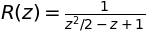

In [212]:
z = sp.Symbol('z')
r_z = sp.Function('R')(z)
display(sp.Eq(r_z, 1/(1 - z + (z**2)/2)))

# Построим матрицу Якоби системы ОДУ для начальных условий

In [99]:
vars = sp.symbols('y1 y2 y3') # определение переменных
f = sp.sympify(['-k1*y1*y2 - k2*y1*y3 + 2*k3*y2 + k4*y3', '0', 'k1*y1*y2 - k2*y1*y3 - k4*y3']) # определение функции
jacoby = sp.zeros(len(f),len(vars)) # создание матрицы нулей с зависимостью f(y)

In [100]:
# заполнение матрицы, теперь это м Якоби 
for i, fi in enumerate(f):
     for j, s in enumerate(vars):
            jacoby[i,j] = sp.diff(fi, s)
display(jacoby)  # вид

⎡-k₁⋅y₂ - k₂⋅y₃  -k₁⋅y₁ + 2⋅k₃  -k₂⋅y₁ + k₄⎤
⎢                                          ⎥
⎢      0               0             0     ⎥
⎢                                          ⎥
⎣k₁⋅y₂ - k₂⋅y₃       k₁⋅y₁      -k₂⋅y₁ - k₄⎦

In [101]:
def float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4):  #  к сожалению, заполнить матрицу числами оказалось не так просто
    values = []
    values.append(-k1*y2_0 - k2*y3_0)  #11
    values.append(-k1*y1_0 + 2*k3)  #12
    values.append(-k2*y1_0 + k4)  #13
    values.append(0)  #21
    values.append(0)  #22
    values.append(0)  #23
    values.append(k1*y2_0 - k2*y3_0)  #31
    values.append(k1*y1_0)  #32
    values.append(-k2*y1_0 - k4)  #33
    return values  # заполняем вручную

In [102]:
j = sp.Matrix(3, 3, float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4))  \
# Якоби в y0 с числами, финальный показательный вариант, там лежат k4(t), надо будет перевычислять j \
# каждый раз, как и kineq[n]
display(j)  # вид

⎡-6.031466  -1.62998e-10  -4.65e-10⎤
⎢                                  ⎥
⎢    0           0            0    ⎥
⎢                                  ⎥
⎣6.030534     1.63e-10    -4.67e-10⎦

# Составим уравнение схемы

In [103]:
gamma = (1+1j)/2
t0 = 0
h = 3456  # шаг
t_end = 172800
e = sp.eye(3)  # E matrix
k3, k4 = 1e-15, 1e-12
j = sp.Matrix(3, 3, float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4)) \
# 2 строки выше - антикраш ImmutableDenseDim (не работает с array), а так там массив
matr = e - gamma*h*j  # a(t) для уравнения a(t)w = f(y0(k(t)))

In [14]:
display(matr) # вид

⎡10423.373248 + 10422.373248⋅ⅈ   2.81660544e-7 + 2.81660544e-7⋅ⅈ     8.0352e-7
⎢                                                                             
⎢              0                                1                             
⎢                                                                             
⎣-10420.762752 - 10420.762752⋅ⅈ    -2.81664e-7 - 2.81664e-7⋅ⅈ     1.0000008069

 + 8.0352e-7⋅ⅈ   ⎤
                 ⎥
  0              ⎥
                 ⎥
76 + 8.06976e-7⋅ⅈ⎦

# Реализация

In [148]:
t = np.linspace(t0, t_end+1, t_end//h)  # задаем значения Ох, шаг h
def rosenbrock(func):  # чудеса реализации; сделаем функцию декоратор для функции задания k3, k4 \
                       #с функцией выбора уравнения выбором поведения функции задания k3, k4
    def especially_for_row_num(row_num):  # with love
        kost = 0  # счетчик для фиксации времени для работы light_dep
        row_num = func(omega, c4, t, row_num)
        assert row_num == 1 or 3
        w = np.arange(0)
        if row_num == 1:
            init_y = y1_0  # выбор y0
        else:
            init_y = y3_0
        y_n = np.array(init_y)  # сюда складываем решение Yn+1 = Yn + hRew, сначала y0
        for _ in np.delete(t, 0):  # нач знач уже лежит на 0 шаге
            k3 = float(func(omega, c3, t[kost]))
            k4 = float(func(omega, c4, t[kost]))
            y = kineq(y1_0, y2_0, y3_0, k1, k2 ,k3, k4)[row_num]
            j = sp.Matrix(3, 3, float_jacoby_filler(y1_0, y2_0, y3_0, k1, k2, k3, k4))
            matr = e - gamma*h*j  # переопредяляем все коэффициенты на каждом шаге \
                                  # _m*w = f(h, y0)
            if row_num!=1:
                _m = matr[6] + matr[7] + matr[8]
                # делаем "деление" на матрицу
            else:
                _m = matr[0] + matr[1] + matr[2]
            # w = np.append(w, (y)/_m); необязательный этап
            y_n = np.append(y_n, init_y + h*sp.re(float(y)/_m))  # Yn+1 = Yn + Rew, _ определят добавление h
            init_y = init_y + h*sp.re(float(y)/_m)
            kost+=1
        return y_n  # массив решений
    return especially_for_row_num # выполнение функции decorated light_dep

In [107]:
@rosenbrock
def light_dep(w, c, t, row_num=None):  # deprecated function from the very beginning - переделал
    if not row_num:
        res = np.arange(0)
        if np.sin(w*t) <= 0.0:
            res = 0
        elif round(np.exp(-c/np.sin(w*t)), 18):  
            res = np.append(res, round(np.exp(-c/np.sin(w*t)), 18))  # поставим здесь границу e-18, и так мало влияет
        if res:
            return res
        else:
            return 0
    else:
        return row_num

In [108]:
y_1 = light_dep(1)  # выполнения решения y1 
y_2 = y2_0
y_3 = light_dep(3)  # подождем еще выполнения решения y3

c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [109]:
display(y_1, y_3)  # вид решений

array([1000000.0, 0.00470680021680892, -999999.974531612,
       -1968912.82789528, 13233.8651348229, 21927117.9463196,
       81354543.3671796, 164748650.638274, 232953884.994095,
       263408236.952842, 268167160.826798, 267314515.622436,
       266314521.161482, 265314521.166189, 264314521.170895,
       263314521.175602, 262314521.180309, 261314521.185016,
       260314521.189723, 259314521.194429, 258314521.199136,
       257314521.203843, 256314521.208550, 255314521.213257,
       254314521.217963, 253314521.222670, 252314521.227377,
       251314786.581832, 250816789.057975, 259762524.673006,
       299686300.155671, 375169113.607983, 455846817.386228,
       505617620.820564, 520283376.750391, 520622515.581976,
       519626594.648916, 518626594.653623, 517626594.658330,
       516626594.663037, 515626594.667744, 514626594.672450,
       513626594.677157, 512626594.681864, 511626594.686571,
       510626594.691278, 509626594.695984, 508626594.700691,
       507626594.705398, 5

array([1000000000000.0, 999999000000.005, 999998000000.025,
       999997031091.976, 999999013606.673, 1000020891121.39,
       1000079633436.12, 1000161220368.65, 1000228407087.58,
       1000258764307.53, 1000263523463.21, 1000262670840.77,
       1000261670846.31, 1000260670846.31, 1000259670846.32,
       1000258670846.32, 1000257670846.33, 1000256670846.33,
       1000255670846.33, 1000254670846.34, 1000253670846.34,
       1000252670846.35, 1000251670846.35, 1000250670846.36,
       1000249670846.36, 1000248670846.37, 1000247670846.37,
       1000246671111.77, 1000246173191.36, 1000255117120.12,
       1000294825465.92, 1000368947067.04, 1000447979639.00,
       1000497340583.31, 1000511995853.61, 1000512335190.82,
       1000511339270.52, 1000510339270.52, 1000509339270.53,
       1000508339270.53, 1000507339270.53, 1000506339270.54,
       1000505339270.54, 1000504339270.55, 1000503339270.55,
       1000502339270.56, 1000501339270.56, 1000500339270.57,
       1000499339270.57, 

In [110]:
def oxygen(): 
    return y_1
def ozone():    # так очевиднее
    return y_3

#  Графики

In [111]:
plt.style.use('seaborn-notebook') 

Text(0, 0.5, 'концентрация ат. кислорода y1(t), см-3')

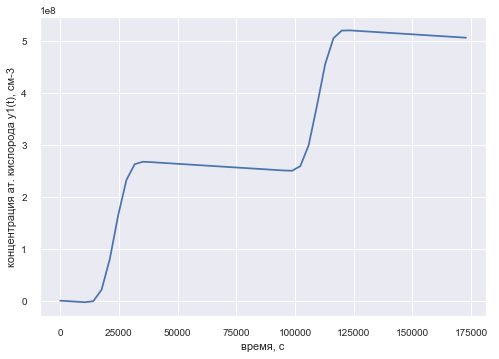

In [113]:
plt.plot(t, oxygen())  # строим кривую решения для кислорода
plt.xlabel('время, с')
plt.ylabel('концентрация ат. кислорода y1(t), см-3')

Text(0, 0.5, 'концентрация озона y3(t), см-3')

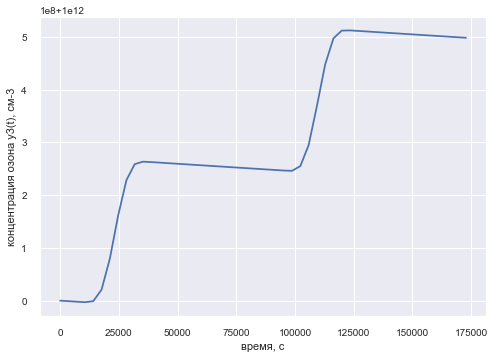

In [114]:
plt.plot(t, ozone())  # строим кривую решения для озона
# plt.scatter(t, ozone(), color='violet') - fun
plt.xlabel('время, с')
plt.ylabel('концентрация озона y3(t), см-3')

# Функция устойчивости

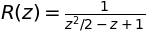

Text(0, 0.5, 'модуль z из C')

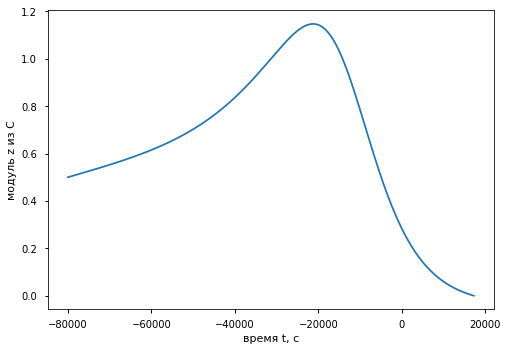

In [318]:
z = sp.Symbol('z')
display(sp.Eq(r_z, 1/(1 - z + (z**2)/2)))
t = np.linspace(-80000, 17280, 1000)
z = np.linspace(0, 1, 1000) + 1j*np.linspace(0, 1, 1000)
x = [x.real for x in z]  # Re
y = [x.imag for x in z]  # Im
plt.plot(t, 1/(1 - z + (z**2))/2)
plt.xlabel('время t, c')
plt.ylabel('модуль z из C')

# |z| < 1 на (-inf, 0] и стремится к нулю

# ............................................

# Часть II
# Реализуем однократно диагональный неявный метод Рунге Кутты с двумя стадиями для случаев
# * 
# **
# ***
# 1. Получим численное решение
# 2. Построим график решения
# 3. Построим функцию устойчивости

# Сначала определим 
## Эталонное решение
В качестве образца использован метод Гаусса, который имеет 6-й порядок аппроксимации. Больше не меньше. Подробнее о методе можно прочитать на странице 47 в книге:
Iserles, Arieh (1996), A First Course in the Numerical Analysis of Differential Equations, Cambridge University Press, ISBN 978-0-521-55655-2
## Да, именно так

In [115]:
def light_dep(w, c, t):  # упрощенная light_dep, просто проверяет условие света 1 раз для данного t
    res = np.arange(0)
    if sp.sin(w*t) <= 0.0:  # 
        res = 0
    elif round(sp.exp(-c/sp.sin(w*t)), 18):  #  поставим здесь границу e-18, и так мало влияет
        res = np.append(res, round(sp.exp(-c/sp.sin(w*t)), 18))  
    if res:
        return res
    else:
        return 0  # если так и не было света (или слишком мало, округлили)

In [116]:
y0 = array([y1_0, y2_0, y3_0])
n_steps = 51  # Количество шагов определяем методом Ньютона; описан в package_tqdm \
# Error: The Newton iteration did not converge.

In [117]:
def dydt(t, y):  # функция для работы с массивом (матрицей) из kineq, \
                 # ожидаемая функция для tqdm
    return np.array(list(kineq(y[0], y[1], y[2], k1, k2, light_dep(omega, c3, t), light_dep(omega, c4, t)).values()))

In [18]:
gauss = Gauss(dydt, y0, t0, t_end, n_steps)

In [19]:
gauss.solve()  # решаем с помощью tqdm

  0%|                                                                                           | 0/52 [00:00<?, ?it/s]c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
100%|██████▍                                                                            | 4/52 [00:00<00:01, 39.62it/s]████████████▊                                                                      | 8/52 [00:00<00:01, 37.71it/s]██████████████████▉                                                               | 12/52 [00:00<00:01, 37.83it/s]█████████████████████████████▉                                                    | 19/52 [00:00<00:00, 43.15it/s]██████████████████████████████████████████▌                                       | 27/52 [00:00<00:00, 48

# Визуализируем зависимость всех переменных от времени

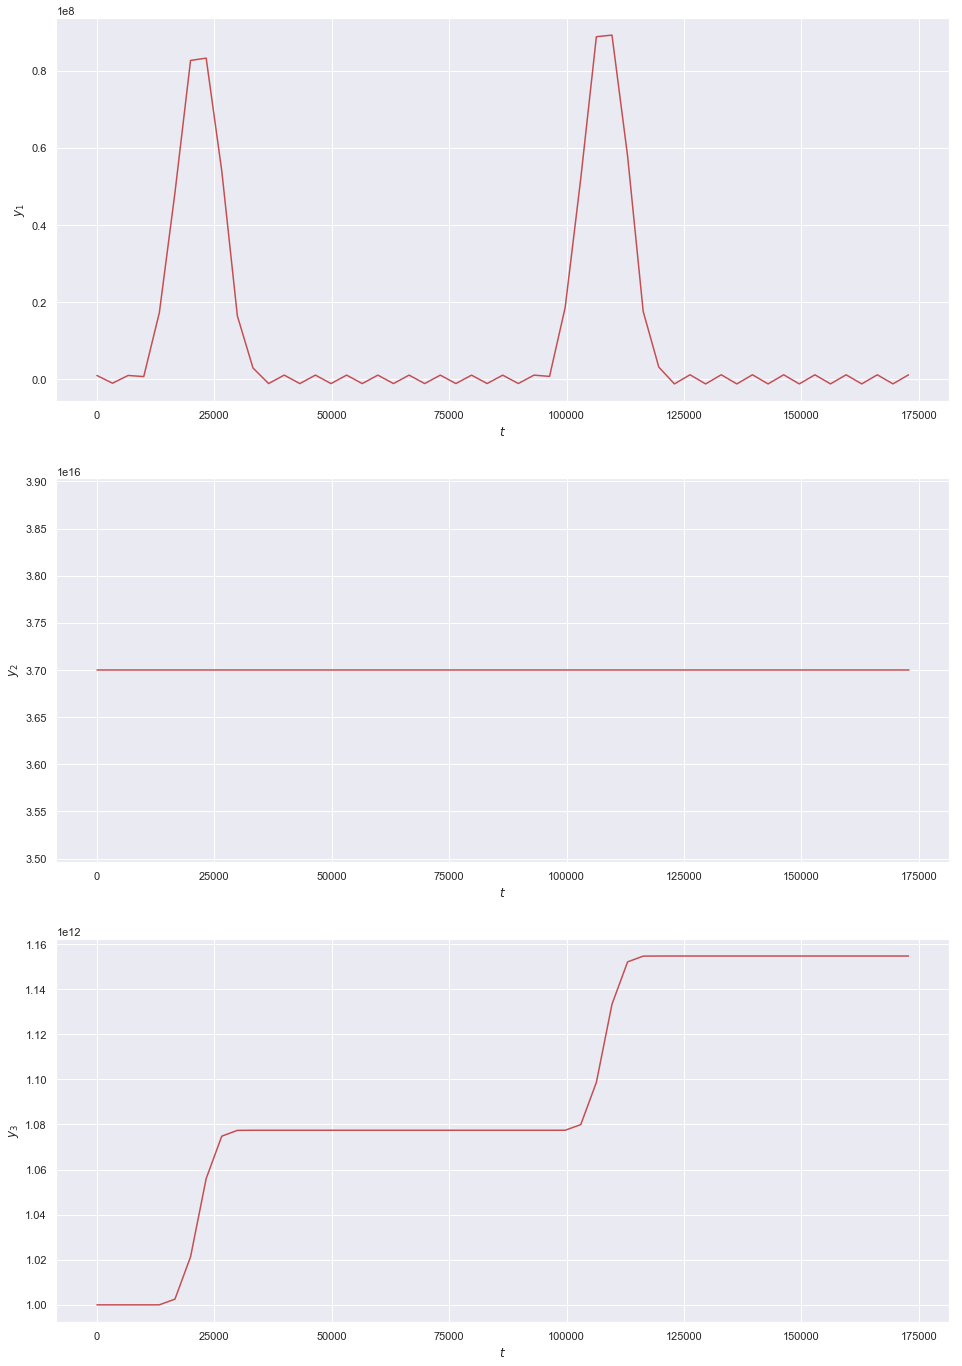

In [20]:
decision = np.array(gauss.solution)  # решение
fig, axes = plt.subplots(3,1, figsize=(16, 24))  
for i, ax in enumerate(axes.flatten()):
    ax.plot(decision[:, 0], decision[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')  # задаем графики
plt.show()  # вид

# Апп Рунге Кутты
# Случай *
# Второго порядка аппроксимации метод с таблицей вида

In [21]:
table_1 = ([(2 + sqrt(2))/2, (2 + sqrt(2))/2, 0, \
            (2 - sqrt(2))/2, (-sqrt(2)), (2 + sqrt(2))/2, \
            0, 0.5, 0.5])  # список коэфф
butcher_table_1 = sp.Matrix(3,3,table_1)  # табилца бутчера в виде матрицы
display(butcher_table_1)

⎡1.70710678118655   1.70710678118655         0        ⎤
⎢                                                     ⎥
⎢0.292893218813452  -1.4142135623731  1.70710678118655⎥
⎢                                                     ⎥
⎣        0                0.5               0.5       ⎦

In [24]:
matr = butcher_table_1
a = np.array([[matr[1], matr[2]], [matr[4], matr[5]]])  # A матрица в таблице
b = np.array([matr[7], matr[8]])  # b вектор в таблице
c = np.array([matr[0], matr[3]])  # c вектор в таблице
rung_dec_1 = RungeImplicit(a, b, c, dydt, y0, t0, t_end, n_steps)

In [25]:
rung_dec_1.solve()  # по факту функция iph solve 

  0%|                                                                                           | 0/52 [00:00<?, ?it/s]c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
100%|███▏                                                                               | 2/52 [00:00<00:02, 17.25it/s]██████▍                                                                            | 4/52 [00:00<00:02, 16.12it/s]███████▉                                                                           | 5/52 [00:00<00:03, 13.09it/s]███████████▏                                                                       | 7/52 [00:00<00:03, 12.69it/s]██████████████▎                                                                    | 9/52 [00:00<00:03, 12

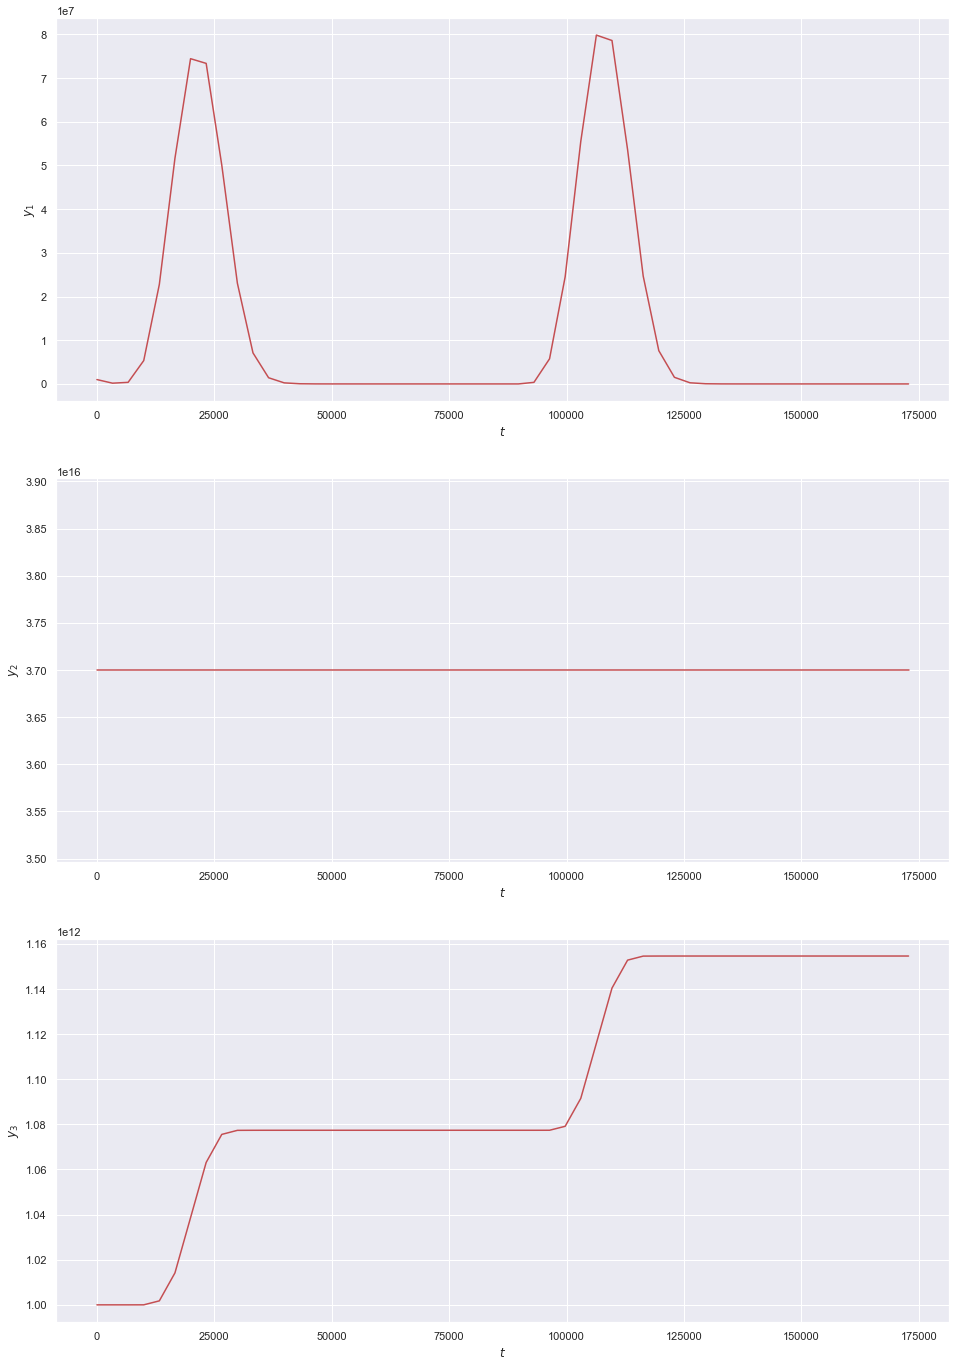

In [26]:
decision = np.array(rung_dec_1.solution)
fig, axes = plt.subplots(3,1, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(decision[:, 0], decision[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()

# Случай **
# Асимптотически устойчивый метод с таблицей вида

In [27]:
table_2 = ([(2 - math.sqrt(2))/2, (2 - math.sqrt(2))/2, 0, \
            (2 + math.sqrt(2))/2, (+math.sqrt(2)), (2 - math.sqrt(2))/2, \
            0, 0.5, 0.5])  # список коэфф
butcher_table_2 = sp.Matrix(3,3,table_1)  # табилца бутчера в виде матрицы
display(butcher_table_2)

⎡1.70710678118655   1.70710678118655         0        ⎤
⎢                                                     ⎥
⎢0.292893218813452  -1.4142135623731  1.70710678118655⎥
⎢                                                     ⎥
⎣        0                0.5               0.5       ⎦

In [29]:
matr = butcher_table_2
a = np.array([[matr[1], matr[2]], [matr[4], matr[5]]])  # A матрица в таблице
b = np.array([matr[7], matr[8]])  # b вектор в таблице
c = np.array([matr[0], matr[3]])  # c вектор в таблице
rung_dec_2 = RungeImplicit(a, b, c, dydt, y0, t0, t_end, n_steps)

In [30]:
rung_dec_2.solve()  # по факту функция iph solve 

  0%|                                                                                           | 0/52 [00:00<?, ?it/s]c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
100%|███▏                                                                               | 2/52 [00:00<00:02, 19.81it/s]██████▍                                                                            | 4/52 [00:00<00:02, 17.07it/s]█████████▌                                                                         | 6/52 [00:00<00:03, 15.00it/s]████████████▊                                                                      | 8/52 [00:00<00:03, 14.10it/s]███████████████▊                                                                  | 10/52 [00:00<00:02, 14

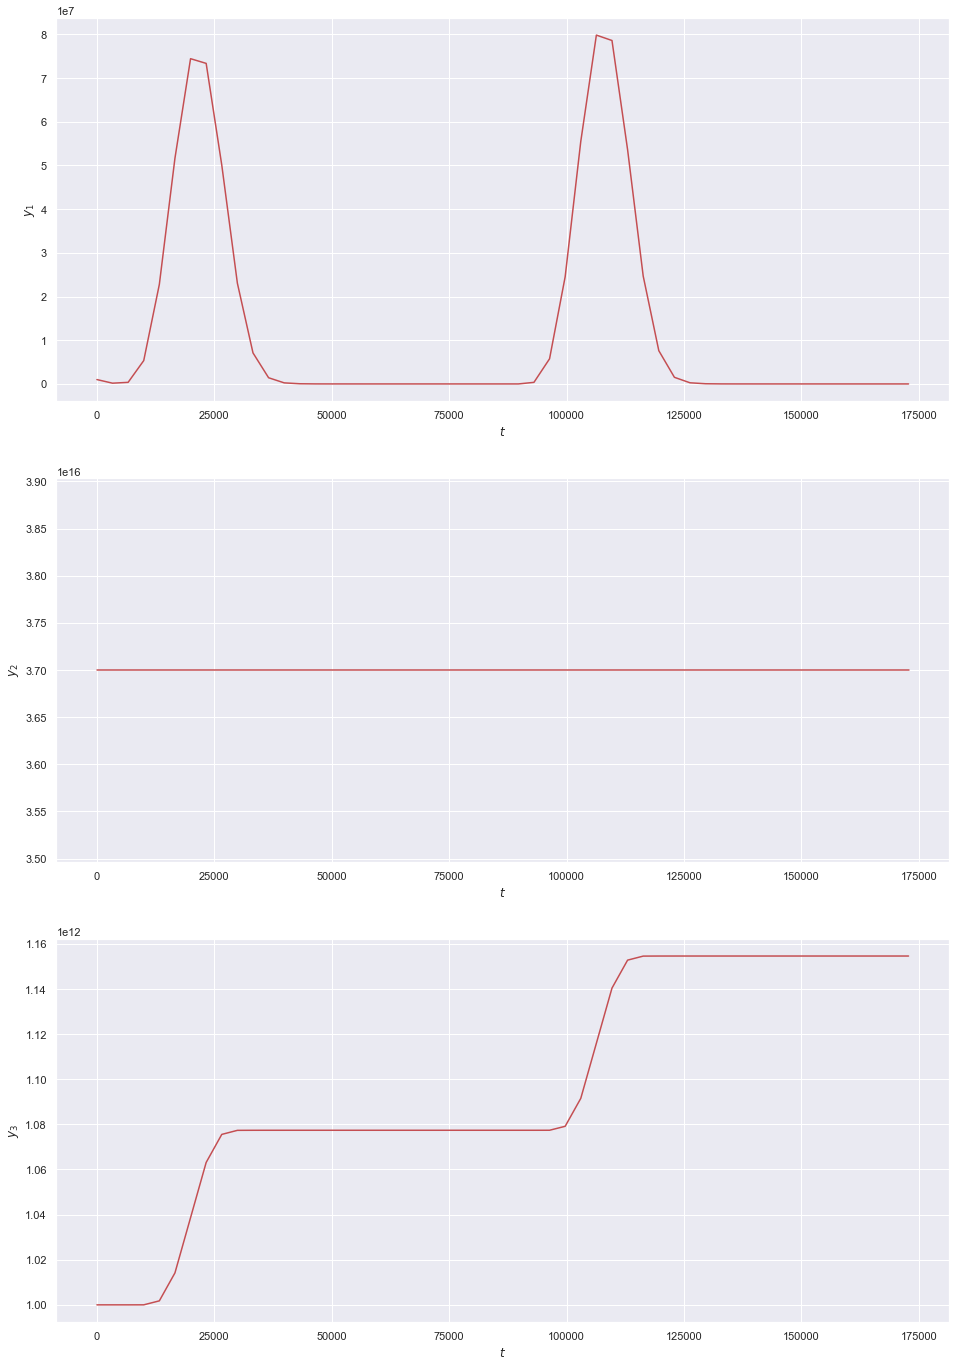

In [89]:
decision = np.array(rung_dec_2.solution)
fig, axes = plt.subplots(3,1, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(decision[:, 0], decision[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()

# Случай ***
# Третьего порядка аппроксимации метод с таблицей вида

In [32]:
table_3 = ([(3 + math.sqrt(3))/6, (3 + math.sqrt(3))/6, 0, \
            (3 - math.sqrt(3))/6, (3 - 2*math.sqrt(3))/6, (3 + math.sqrt(3))/6, \
            0, 0.5, 0.5])  # список коэфф
butcher_table_3 = sp.Matrix(3,3,table_1)  # табилца бутчера в виде матрицы
display(butcher_table_3)

⎡1.70710678118655   1.70710678118655         0        ⎤
⎢                                                     ⎥
⎢0.292893218813452  -1.4142135623731  1.70710678118655⎥
⎢                                                     ⎥
⎣        0                0.5               0.5       ⎦

In [33]:
matr = butcher_table_3
a = np.array([[matr[1], matr[2]], [matr[4], matr[5]]])  # A матрица в таблице
a
b = np.array([matr[7], matr[8]])  # b вектор в таблице
c = np.array([matr[0], matr[3]])  # c вектор в таблице
rung_dec_3 = RungeImplicit(a, b, c, dydt, y0, t0, t_end, n_steps)

In [34]:
rung_dec_3.solve()  # по факту функция iph solve 

  0%|                                                                                           | 0/52 [00:00<?, ?it/s]c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
100%|████▊                                                                              | 3/52 [00:00<00:02, 19.24it/s]███████▉                                                                           | 5/52 [00:00<00:03, 14.86it/s]███████████▏                                                                       | 7/52 [00:00<00:03, 13.18it/s]██████████████▎                                                                    | 9/52 [00:00<00:03, 12.74it/s]█████████████████▎                                                                | 11/52 [00:00<00:03, 13

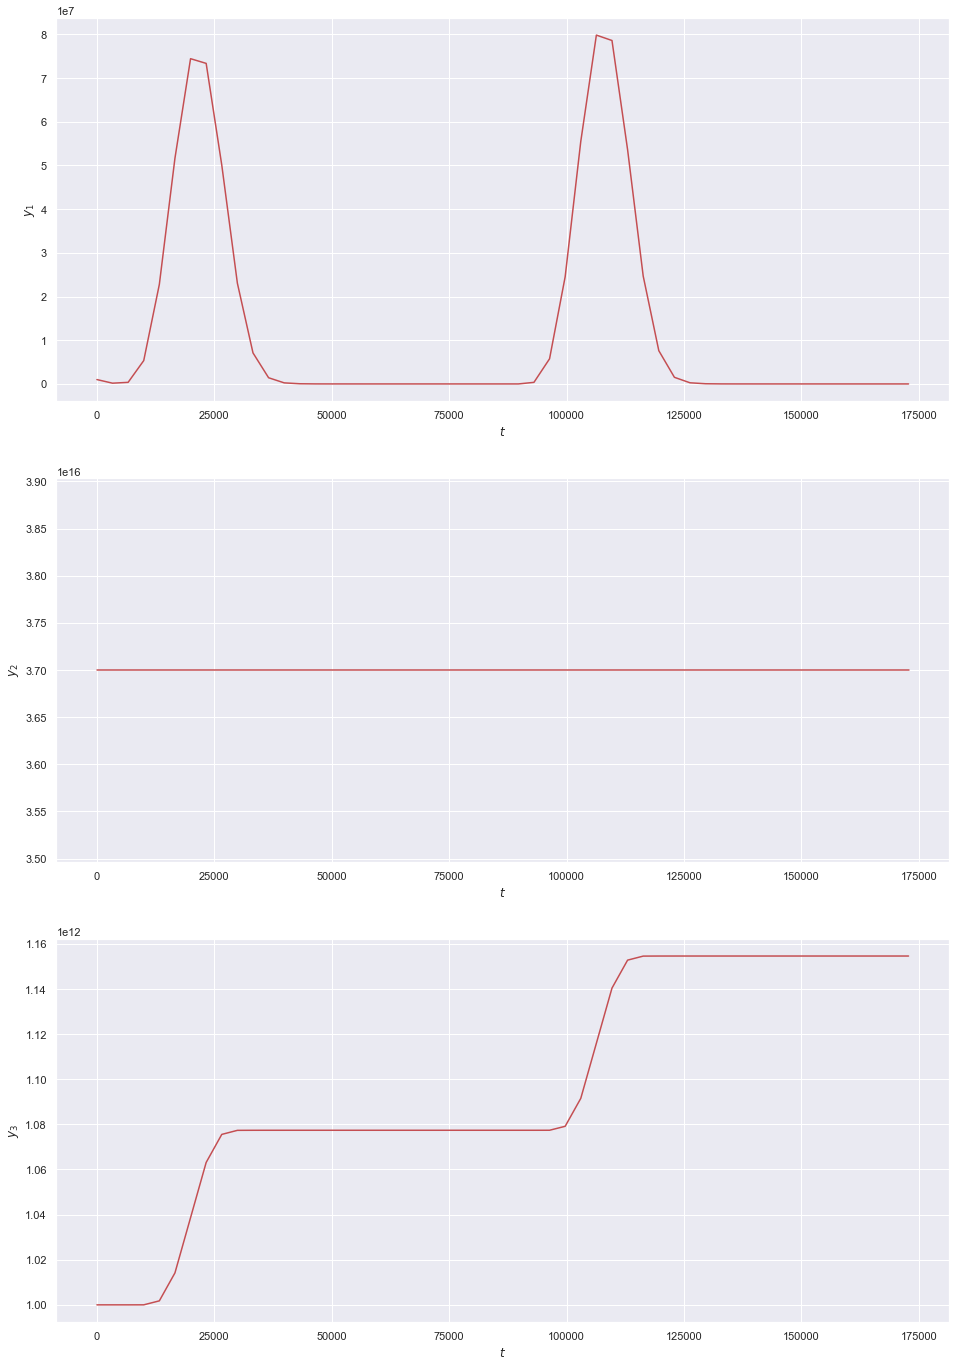

In [35]:
decision = np.array(rung_dec_3.solution)
fig, axes = plt.subplots(3,1, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(decision[:, 0], decision[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()

# Часть III. Формулы дифференцирования назад (ФДН)
## Выполним все действия предыдущего пункта для формул дифференцирования назад и получим также решение при помощи метода в представлении Нордсика

In [37]:
bdf_sol = bdf2(dydt, y0, t0, t_end, n_steps)
bdf_sol = np.vstack((bdf_sol.t, bdf_sol.y)).T
bdf_sol_nord = bdf2_nord(f, y0, t0, t_end, n_steps)
bdf_sol_nord = np.vstack((bdf_sol_nord.t, bdf_sol_nord.y)).T  # реализация ФДН

# Часть IV. Метод CROS

In [118]:
cros = CROS(dydt, y0, t0, t_end, n_steps)

In [119]:
cros.solve()

  0%|                                                                                           | 0/52 [00:00<?, ?it/s]c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
c:\users\константин игоревич\appdata\local\programs\python\python37-32\lib\site-packages\scipy\linalg\decomp_lu.py:146: ComplexWarning: Casting complex values to real discards the imaginary part
  x, info = getrs(lu, piv, b1, trans=trans, overwrite_b=overwrite_b)
100%|███████████▏                                                                       | 7/52 [00:00<00:00, 68.65it/s]███████████████████████▋                                                          | 15/52 [00:00<00:00, 70.81it/s]████████████████████████████████████████████████▉                     

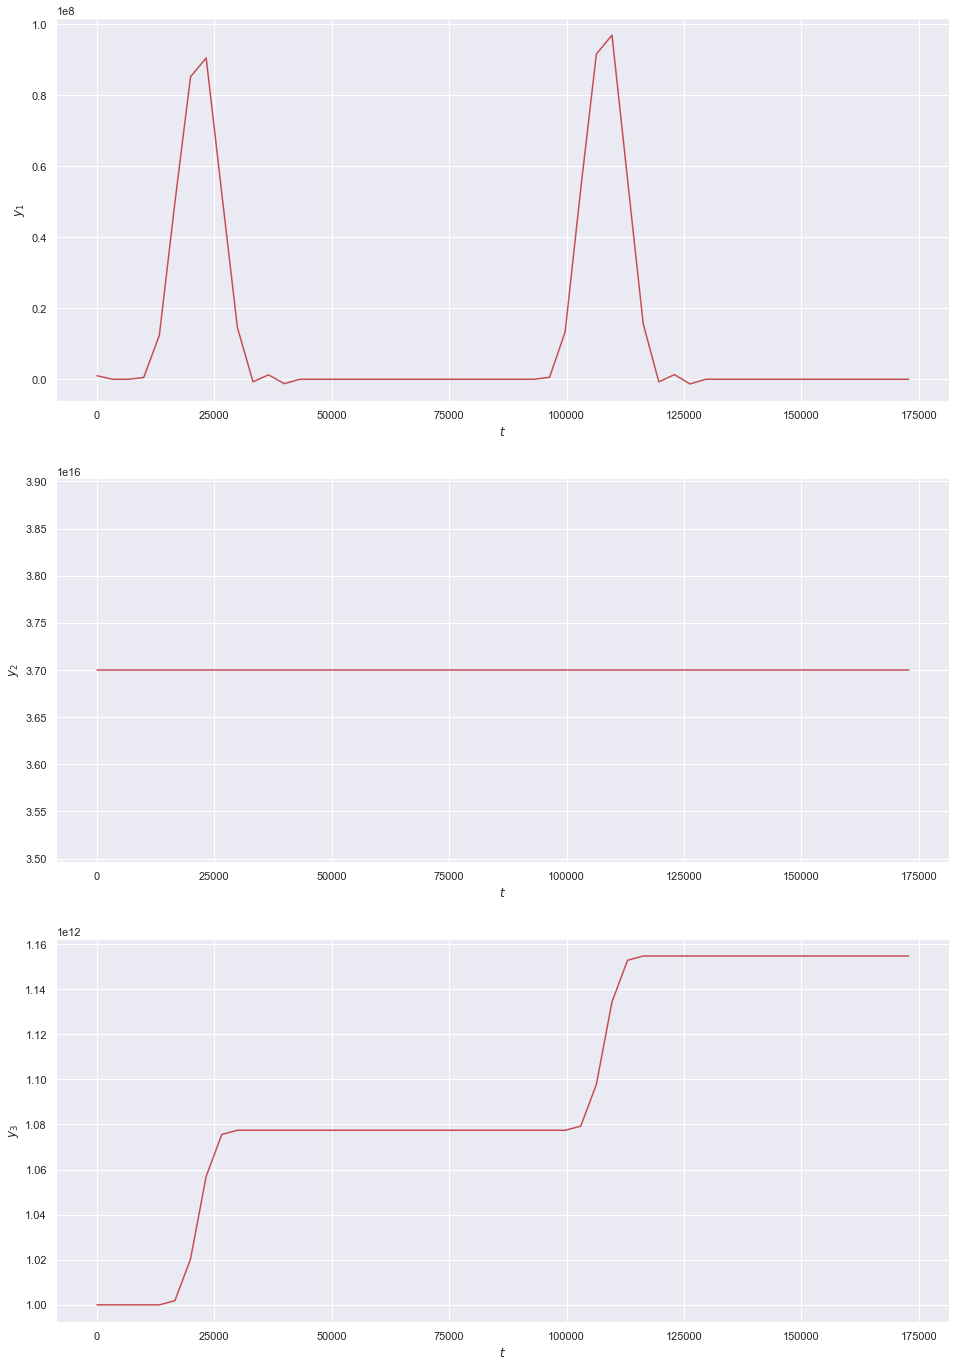

In [40]:
decision = np.array(cros.solution)
fig, axes = plt.subplots(3,1, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(decision[:, 0], decision[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()

# Сравним результаты

Для сравнения результатов с эталоном рассчитаем абсолютную ошибку по переменным $y_3$, $y_5$, $y_8$ и визуализируем её

In [68]:
solutions  = {'rung_dec_1': array(rung_dec_1.solution),
              'rung_dec_2':array(rung_dec_2.solution),
              'rung_dec_3':array(rung_dec_3.solution),
              'CROS':array(cros.solution)}
m = [1e-12, 1, 1e-14]

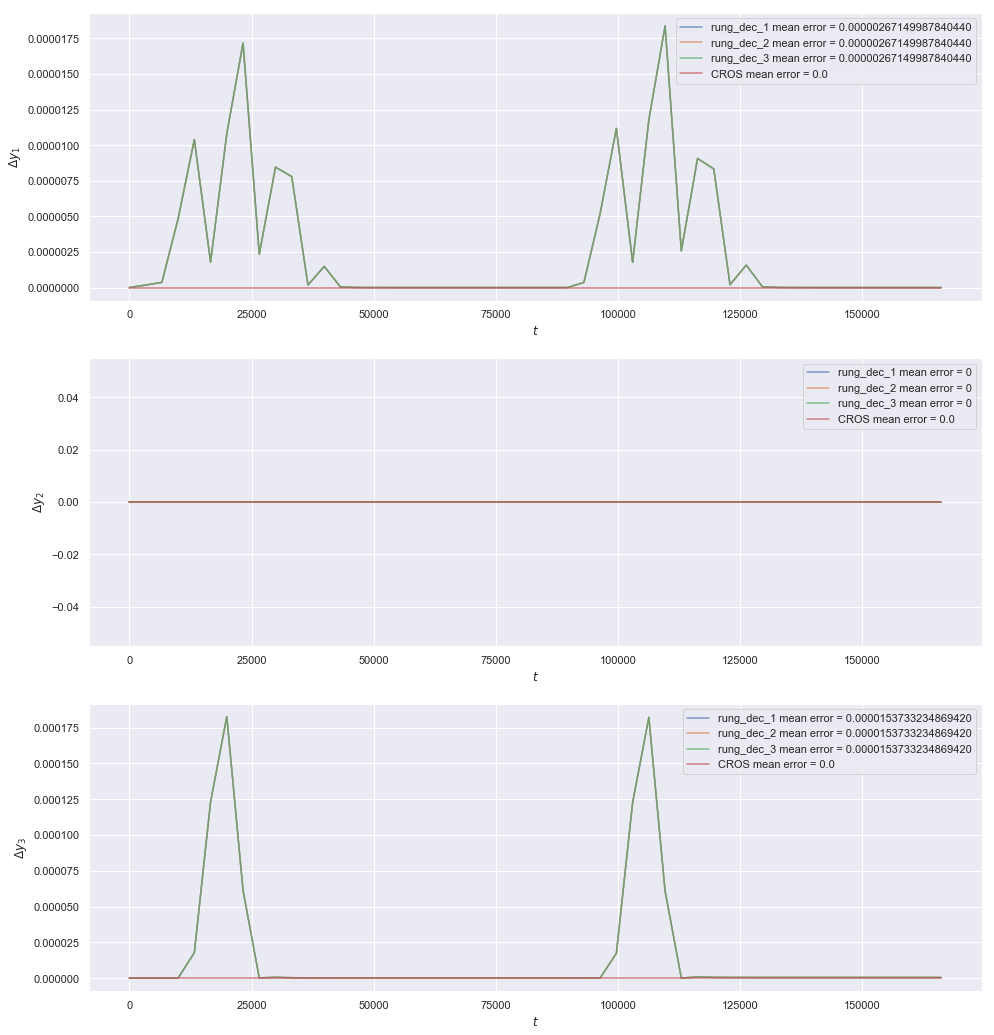

In [69]:
fig, axes = plt.subplots(3,1, figsize=(16, 18))
var = [1, 2, 3]
for i, ax in enumerate(axes.flatten()):
    for model in solutions:
        differ = np.abs(solutions[model][:, var[i]][:n_steps] - decision[:, var[i]][:n_steps])*m[i]
        ax.plot(decision[:, 0][:n_steps], differ[:n_steps], label=model+' mean error = {}'.format(differ.mean()), alpha=0.7)
    ax.legend()
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$\Delta y_{'+str(var[i])+'}$')
plt.show()

# Наилучшим методом признаем CROS

# Функции устойчивости использованных методов

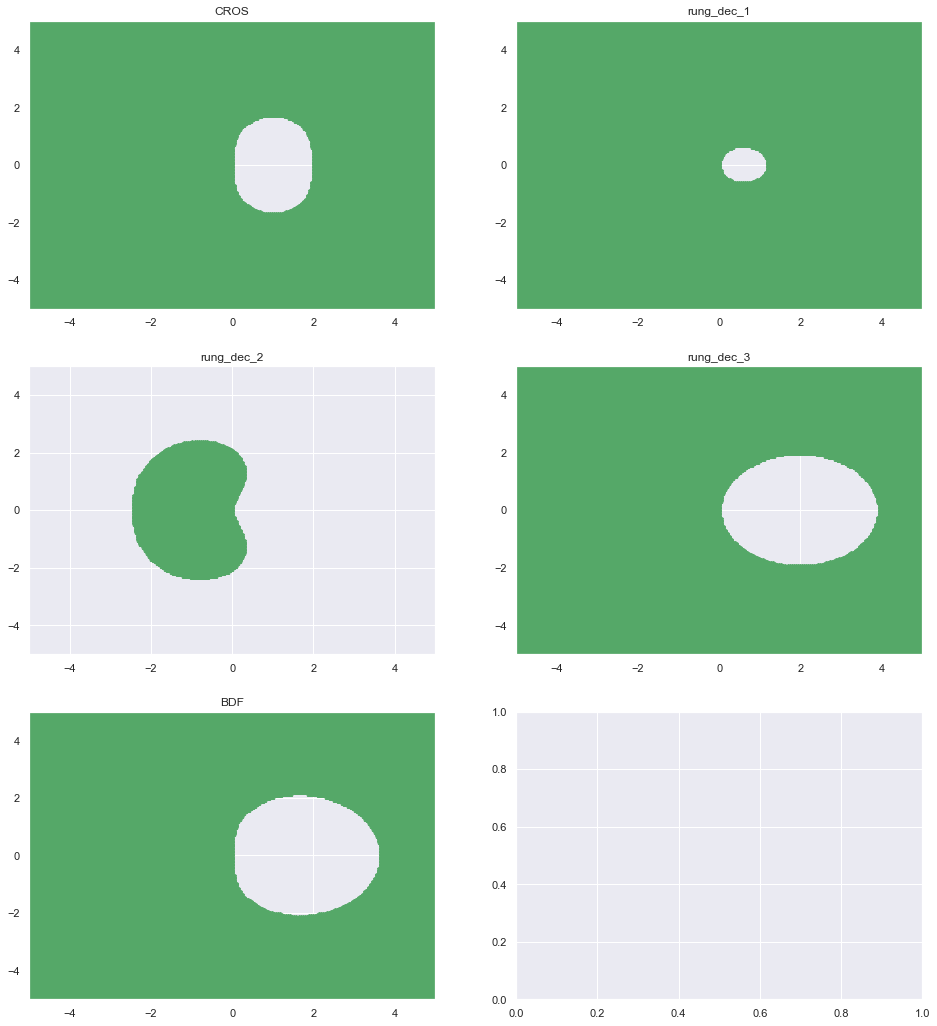

In [93]:
def plot_stability_area(ax, f, xlim, ylim):
    X = np.linspace(*xlim, 200)
    Y = np.linspace(*ylim, 200)
    X_p = []
    Y_p = []
    for x in X:
        for y in Y:
            if abs(f(complex(x, y))) <= 1:
                X_p.append(x)
                Y_p.append(y)
    ax.plot(X_p, Y_p, 'gp',  alpha=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

stability_functions = {
    'CROS': lambda z: 1/(1-z+(z*z)/2),
    'rung_dec_1': lambda z: 0.5*z*(-1.4142135623731*z/(-1.70710678118655*z + 1) + 1.0)/(-1.70710678118655*z + 1) + 0.5*z/(-1.70710678118655*z + 1) + 1,
    'rung_dec_2': lambda z: 0.5*z*(1.4142135623731*z/(-0.292893218813452*z + 1) + 1.0)/(-0.292893218813452*z + 1) + 0.5*z/(-0.292893218813452*z + 1) + 1,
    'rung_dec_3': lambda z: 0.5*z*(-0.0773502691896257*z/(-0.788675134594813*z + 1) + 1.0)/(-0.788675134594813*z + 1) + 0.5*z/(-0.788675134594813*z + 1) + 1,
    'BDF': lambda z: ((1-z**2)-0.5*z**2)/(1-z)**3,
}

fig, axes = plt.subplots(3, 2, figsize = (16, 18))
axes = axes.flatten()
for i, stab in enumerate(stability_functions):
    plot_stability_area(axes[i], stability_functions[stab], [-5, 5], [-5, 5])
    axes[i].set_title(stab)

In [94]:
from nodepy import runge_kutta_method as rk
gauss = rk.loadRKM('GL3')
fig = gauss.plot_stability_region(N=100, color='green', bounds=[-5, 5, -5, 5])
fig.set_size_inches((10, 6))
plt.show()

ModuleNotFoundError: No module named 'nodepy'

## Среди используемых методов CROS, SDIRK1, SDIRK3 и BDF оказались А-устойчивыми. Методы CROS и BDF также являются L-устойчивым. В данной задаче размер области устойчивочти слабо соотносится с предпочтительностью методов. Принципиальными являются A- (то есть вхождение в состав области левой полуплоскости) и L-устойчивости, а также порядок аппроксимации методов.

